In [ ]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [ ]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

# פתרון תרגול: התפלגות מהירות מקסוול–בולצמן (MB) 

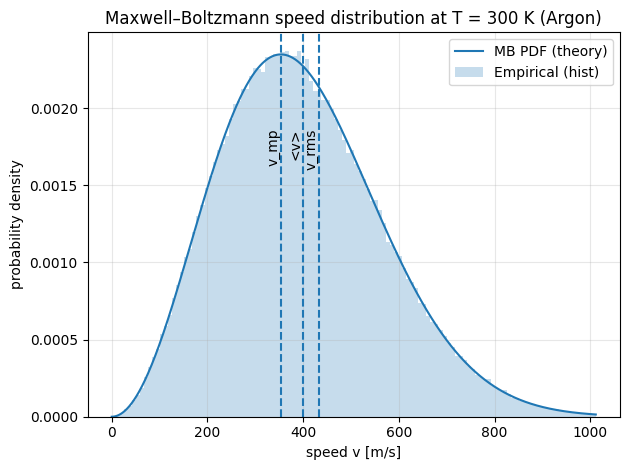

--- T = 300 K (Argon) ---
Theoretical v_mp  ≈    353.4 m/s | Empirical mode ≈    391.9 m/s
Theoretical <v>   ≈    398.7 m/s | Empirical mean ≈    398.9 m/s
Theoretical v_rms ≈    432.8 m/s | Empirical rms  ≈    433.1 m/s


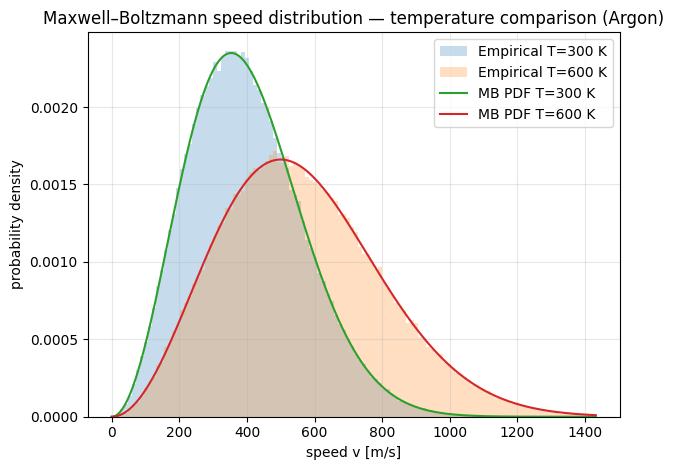


--- T = 600 K (Argon) ---
Theoretical v_mp  ≈    499.8 m/s
Theoretical <v>   ≈    563.9 m/s | Empirical mean ≈    563.7 m/s
Theoretical v_rms ≈    612.1 m/s | Empirical rms  ≈    611.8 m/s

√T scaling checks (theory):
v_mp(T2)/v_mp(T1)   ≈ 1.414  (expected ≈ sqrt(2.0) = 1.414)
<v>(T2)/<v>(T1)     ≈ 1.414  (expected ≈ sqrt(2.0) = 1.414)
v_rms(T2)/v_rms(T1) ≈ 1.414  (expected ≈ sqrt(2.0) = 1.414)

PDF normalization check (numerical, finite grid): area @300K ≈ 1.00000, area @600K ≈ 0.99907


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Physical constants & settings
# -----------------------------
k_B = 1.380649e-23         # Boltzmann constant [J/K]
u   = 1.66053906660e-27    # atomic mass unit [kg]

# We'll model Argon gas (approx. 39.948 u):
m_Ar = 39.948 * u          # mass per particle [kg]

# Temperatures to compare
T1 = 300.0                 # [K]
T2 = 600.0                 # [K]
N  = 200_000               # number of samples

rng = np.random.default_rng(42)  # reproducible randomness

# -----------------------------
# Helper: Maxwell–Boltzmann PDF
# -----------------------------
def mb_pdf(v, m, T):
    """
    3D Maxwell–Boltzmann speed distribution
    Parameters
    ----------
    v : array-like, speeds [m/s], v >= 0
    m : mass [kg]
    T : temperature [K]
    """
    v = np.asarray(v)
    coef = 4.0 * np.pi * (m / (2.0 * np.pi * k_B * T))**1.5
    return coef * (v**2) * np.exp(-m * v**2 / (2.0 * k_B * T))


# ==========================
# PART A — One temperature
# ==========================
# TODO (1): Generate N samples of vx, vy, vz for a gas at temperature T1.
#           Recall that each velocity component is Gaussian with variance k_B T / m.
# ANSWER:
sigma1 = np.sqrt(k_B * T1 / m_Ar)  # std of each velocity component
vx1 = rng.normal(0.0, sigma1, size=N)
vy1 = rng.normal(0.0, sigma1, size=N)
vz1 = rng.normal(0.0, sigma1, size=N)

# TODO (2): Compute the speed array v = sqrt(vx^2 + vy^2 + vz^2).
# ANSWER:
v1 = np.sqrt(vx1**2 + vy1**2 + vz1**2)


# TODO (3a): Compute histogram quantities and theoretical PDF values (no plotting here).
bins = 120
vmax = np.percentile(v1, 99.9)                  # upper x-limit near the tail
v_grid = np.linspace(0.0, vmax, 800)            # smooth grid for theory curve
counts, edges = np.histogram(                    # normalized histogram data
    v1, bins=bins, range=(0.0, vmax), density=True
)
pdf_grid = mb_pdf(v_grid, m_Ar, T1)             # theoretical MB PDF on the grid

# TODO (3b): Compute characteristic speeds for T1 (no plotting here).
v_mp_1   = np.sqrt(2.0 * k_B * T1 / m_Ar)
v_mean_1 = np.sqrt(8.0 * k_B * T1 / (np.pi * m_Ar))
v_rms_1  = np.sqrt(3.0 * k_B * T1 / m_Ar)

# -----------------------------
# Plotting (in two separate steps)
# -----------------------------

# TODO (4a): Plot the normalized histogram + theoretical MB curve.
fig, ax = plt.subplots()
# Plot precomputed histogram with bar-style so we don't recompute counts:
ax.bar(edges[:-1], counts, width=np.diff(edges), align="edge", alpha=0.25, label="Empirical (hist)")
ax.plot(v_grid, pdf_grid, label="MB PDF (theory)")
ax.set_xlabel("speed v [m/s]")
ax.set_ylabel("probability density")
ax.set_title("Maxwell–Boltzmann speed distribution at T = 300 K (Argon)")
ax.legend()
ax.grid(True, alpha=0.3)

# TODO (4b): Add vertical lines for v_mp, <v>, v_rms (after the plot so ylim is known).
y_top = ax.get_ylim()[1] * 0.75
for val, name in [(v_mp_1, "v_mp"), (v_mean_1, "<v>"), (v_rms_1, "v_rms")]:
    ax.axvline(val, linestyle="--")
    ax.text(val, y_top, name, rotation=90, va="top", ha="right")

fig.tight_layout()
plt.show()


# TODO (5): Estimate the empirical mode (from the histogram), mean, and RMS from the samples.
#           Print both theoretical and empirical values for comparison.
# ANSWER:
centers = 0.5 * (edges[:-1] + edges[1:])
mode_idx = np.argmax(counts)
v_mode_emp = centers[mode_idx]
v_mean_emp = np.mean(v1)
v_rms_emp  = np.sqrt(np.mean(v1**2))

print("--- T = 300 K (Argon) ---")
print(f"Theoretical v_mp  ≈ {v_mp_1:8.1f} m/s | Empirical mode ≈ {v_mode_emp:8.1f} m/s")
print(f"Theoretical <v>   ≈ {v_mean_1:8.1f} m/s | Empirical mean ≈ {v_mean_emp:8.1f} m/s")
print(f"Theoretical v_rms ≈ {v_rms_1:8.1f} m/s | Empirical rms  ≈ {v_rms_emp:8.1f} m/s")


# ==========================================
# PART B — Compare two temperatures on one plot
# ==========================================
# TODO (6): Repeat the sampling for T2 and compute the corresponding speeds v2.
# ANSWER:
sigma2 = np.sqrt(k_B * T2 / m_Ar)
vx2 = rng.normal(0.0, sigma2, size=N)
vy2 = rng.normal(0.0, sigma2, size=N)
vz2 = rng.normal(0.0, sigma2, size=N)
v2 = np.sqrt(vx2**2 + vy2**2 + vz2**2)

# TODO (7): Overlay histograms for T1 and T2 on the same axes (normalized), and draw their MB PDFs.
#           Use the same vmax for a fair comparison (or extend to T2's 99.9 percentile if larger).
# ANSWER:
vmax_2 = max(vmax, np.percentile(v2, 99.9))
v_grid2 = np.linspace(0.0, vmax_2, 800)

plt.figure()
plt.hist(v1, bins=bins, range=(0.0, vmax_2), density=True, alpha=0.25, label="Empirical T=300 K")
plt.hist(v2, bins=bins, range=(0.0, vmax_2), density=True, alpha=0.25, label="Empirical T=600 K")
plt.plot(v_grid2, mb_pdf(v_grid2, m_Ar, T1), label="MB PDF T=300 K")
plt.plot(v_grid2, mb_pdf(v_grid2, m_Ar, T2), label="MB PDF T=600 K")

plt.xlabel("speed v [m/s]")
plt.ylabel("probability density")
plt.title("Maxwell–Boltzmann speed distribution — temperature comparison (Argon)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# TODO (8): Compute and print the three characteristic speeds for T2, and briefly verify the √T scaling.
# ANSWER:
v_mp_2   = np.sqrt(2.0 * k_B * T2 / m_Ar)
v_mean_2 = np.sqrt(8.0 * k_B * T2 / (np.pi * m_Ar))
v_rms_2  = np.sqrt(3.0 * k_B * T2 / m_Ar)

v_mean_emp_2 = np.mean(v2)
v_rms_emp_2  = np.sqrt(np.mean(v2**2))

print("\n--- T = 600 K (Argon) ---")
print(f"Theoretical v_mp  ≈ {v_mp_2:8.1f} m/s")
print(f"Theoretical <v>   ≈ {v_mean_2:8.1f} m/s | Empirical mean ≈ {v_mean_emp_2:8.1f} m/s")
print(f"Theoretical v_rms ≈ {v_rms_2:8.1f} m/s | Empirical rms  ≈ {v_rms_emp_2:8.1f} m/s")

print("\n√T scaling checks (theory):")
print(f"v_mp(T2)/v_mp(T1)   ≈ {v_mp_2/v_mp_1:5.3f}  (expected ≈ sqrt({T2/T1:.1f}) = {np.sqrt(T2/T1):.3f})")
print(f"<v>(T2)/<v>(T1)     ≈ {v_mean_2/v_mean_1:5.3f}  (expected ≈ sqrt({T2/T1:.1f}) = {np.sqrt(T2/T1):.3f})")
print(f"v_rms(T2)/v_rms(T1) ≈ {v_rms_2/v_rms_1:5.3f}  (expected ≈ sqrt({T2/T1:.1f}) = {np.sqrt(T2/T1):.3f})")


# ==========================================
# PART C — Optional: PDF normalization sanity check
# ==========================================
# TODO (9) [Optional]: Numerically integrate the theoretical PDF over v≥0 and show it is ~1.
# ANSWER:
from numpy import trapezoid
area_300 = trapezoid(mb_pdf(v_grid2, m_Ar, T1), x=v_grid2)
area_600 = trapezoid(mb_pdf(v_grid2, m_Ar, T2), x=v_grid2)
print(f"\nPDF normalization check (numerical, finite grid): area @300K ≈ {area_300:.5f}, area @600K ≈ {area_600:.5f}")
